In [1]:
import numpy as np
import scipy.io as sio 
import scipy.signal as sig
from matplotlib import pyplot as plt
%matplotlib inline
dat = sio.loadmat('sub2_comp.mat',struct_as_record = True)

In [59]:
train_data = dat['train_data']
train_dg = dat['train_dg']
samples,channels = train_data.shape
tt = 400 #Sampling time
sf = 1000 #Sampling frequency 
channel_data = np.transpose(train_data,(1,0))
finger_data = np.transpose(train_dg,(1,0))

In [4]:
# FIR filter 
def bandPass(signal,fl,fh):
    taps = 505
    band = np.array([fl,fh])
    h = sig.firwin(taps,band,fs=sf,pass_zero='bandpass')
    output = np.convolve(signal,h,mode='same')
    return output

In [5]:
# Amplitude modulation : 
def AM(signal):
    cur = 0
    output = []
    for i in range(samples):
        if(i and i % 40 == 0):
            output.append(cur)
            cur = 0
        cur += signal[i]**2
    output.append(cur)
         
    return output

In [6]:
# Seperate channel_data into frequency bands : 
sub_band = [bandPass(x,1,60) for x in channel_data]
gamma_band = [bandPass(x,60,100) for x in channel_data]
fast_gamma_band = [bandPass(x,100,200) for x in channel_data]

In [7]:
# Perform amplitude modulation on each band :
sub_band = np.array([AM(x) for x in sub_band])
gamma_band = np.array([AM(x) for x in gamma_band])
fast_gamma_band = np.array([AM(x) for x in fast_gamma_band])

In [81]:
# Finger data downsampling : 
finger_data_ds = [None]*5
for i in range(5):
    finger_data_ds[i] = [finger_data[i][j] for j in range(0,samples,40)]

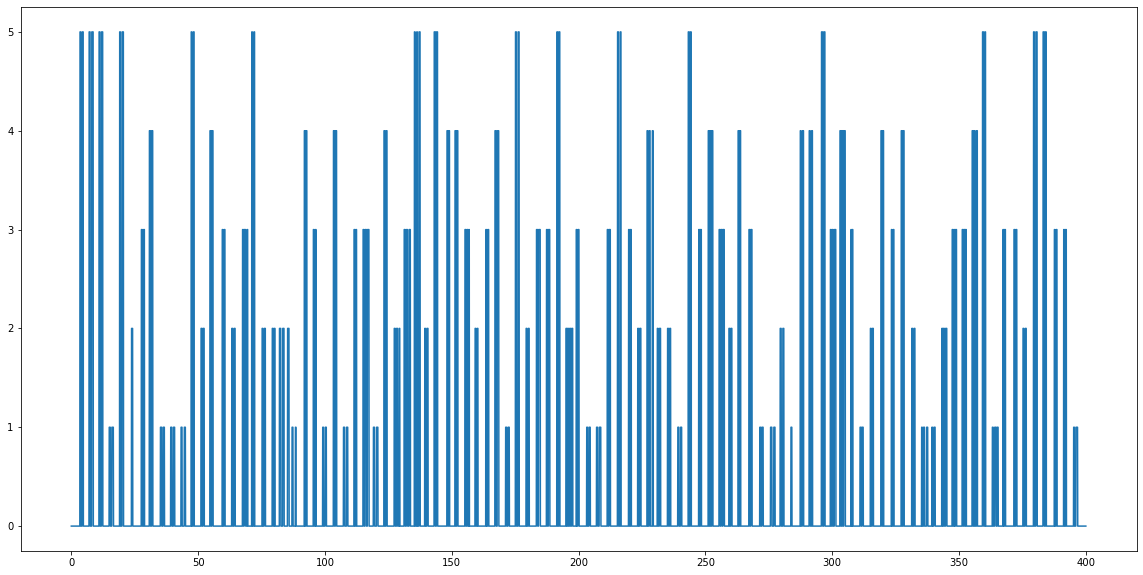

In [82]:
# State assignment : (0 : rest, 1-5 finger flexed)
dsamples = len(finger_data_ds[0])
states = [None]*dsamples
threshold_1,threshold_2  = 2.0,1.0
for i in range(dsamples):
    flex,rest = 0,0
    for j in range(5):
        if finger_data_ds[j][i] >= threshold_1:
            states[i] = j + 1
            flex += 1
        elif finger_data_ds[j][i] < threshold_2:
            rest += 1
    if states[i] == None:
        if rest:
            states[i] = 0

plt.plot(np.linspace(0,400,400*25),states)